In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print(torch.__version__)

1.5.1


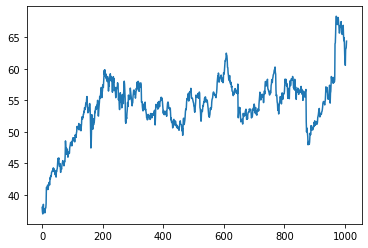

In [4]:
data = pd.read_csv('starbucks.csv')

data['Close'].plot()
plt.show()

In [5]:
train = data['Close'][:800].reset_index(drop=True)
valid = data['Close'][800:].reset_index(drop=True)

In [6]:
class WindowedDataset(Dataset):
    
    def __init__(self, series, windowSize):
        self.X = []
        self.y = []
        for idx in range(0,len(series) - windowSize):
            self.X = np.append(self.X, series[idx:idx+windowSize])
            self.y = np.append(self.y, series[idx+windowSize])
        self.X = self.X.reshape(-1, windowSize)
        self.y = self.y.reshape(-1,1)

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X = torch.Tensor(self.X[idx])
        y = torch.Tensor(self.y[idx])
        return X, y

In [175]:
window = 10
windowedDataset = WindowedDataset(train, windowSize=window)
loader = DataLoader(windowedDataset, batch_size=4, shuffle=True)

In [176]:
class DNN(nn.Module):
    def __init__(self, inputSize, hiddenSize, outputSize):
        super().__init__()
        
        self.layer1 = nn.Linear(inputSize, hiddenSize)
        self.layer2 = nn.Linear(hiddenSize, outputSize)
        self.relu = nn.ReLU()
            
    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out) 
        out = self.layer2(out)
        return out

In [177]:
modelDNN = DNN(window,50,1)

In [178]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(modelDNN.parameters(), lr=0.01)
lrScheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99)

In [179]:
numEpochs = 500
nTotalStep = len(loader)
for epoch in tqdm_notebook(range(numEpochs)):
    for idx, (feature, target) in enumerate(loader):
        
        yPred = modelDNN(feature)
        loss = criterion(yPred, target)
        
        optimizer.zero_grad()
        loss.backward()
        lrScheduler.step()
        
    if (epoch+1) % 10 == 0:
        print(f'epoch : {epoch+1} / {numEpochs},loss : {loss.item()}')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


epoch : 10 / 500,loss : 1940.564453125
epoch : 20 / 500,loss : 1764.3892822265625
epoch : 30 / 500,loss : 1976.802978515625
epoch : 40 / 500,loss : 1938.34326171875
epoch : 50 / 500,loss : 1505.01513671875
epoch : 60 / 500,loss : 2065.7177734375
epoch : 70 / 500,loss : 1973.994140625
epoch : 80 / 500,loss : 2138.18212890625
epoch : 90 / 500,loss : 2205.9912109375
epoch : 100 / 500,loss : 1705.389892578125
epoch : 110 / 500,loss : 1962.14892578125
epoch : 120 / 500,loss : 2158.123291015625
epoch : 130 / 500,loss : 1782.191650390625
epoch : 140 / 500,loss : 2023.2197265625
epoch : 150 / 500,loss : 1817.0380859375
epoch : 160 / 500,loss : 2041.4473876953125
epoch : 170 / 500,loss : 1918.75439453125
epoch : 180 / 500,loss : 1920.4384765625
epoch : 190 / 500,loss : 1892.2845458984375
epoch : 200 / 500,loss : 1773.522705078125
epoch : 210 / 500,loss : 1465.6146240234375
epoch : 220 / 500,loss : 1769.60107421875
epoch : 230 / 500,loss : 1938.724365234375
epoch : 240 / 500,loss : 2175.81640625

In [183]:
window = 10
windowedDatasetValid = WindowedDataset(valid, windowSize=window)
loaderValid = DataLoader(windowedDatasetValid, batch_size=8, shuffle=True)
forecast = []
with torch.no_grad():
        for idx, (feature, target) in enumerate(loaderValid):
            output = modelDNN(feature)
            forecast = np.append(forecast, output)

In [184]:
forecast.shape

(196,)

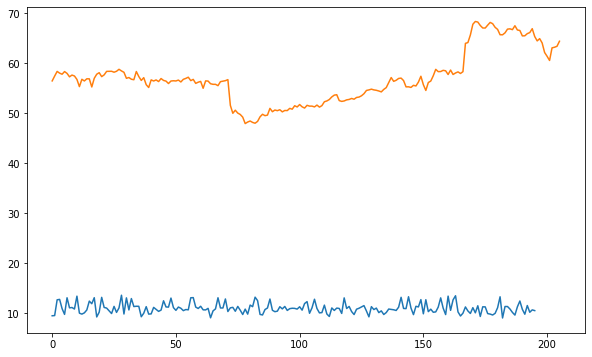

In [185]:
plt.figure(figsize=(10, 6))

plt.plot(forecast)
plt.plot(valid)

Shit...